In [19]:

from datetime import datetime
import time
import os
from tqdm import tqdm
import pandas as pd
import re
import matplotlib.pyplot as plt

import numpy as np
import nltk
from nltk.corpus import stopwords
import pyLDAvis.gensim_models
import jieba.posseg as jp,jieba
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import warnings
import sklearn
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib
import jieba
from ark_nlp.factory.utils.conlleval import get_entity_bio

In [20]:
total_septext_list = []
total_bio_list = []
t = []
# with open('../datasets/sample_datasets/train_500.txt', encoding='UTF-8') as f:
with open('./train_9.txt', encoding='UTF-8') as f:
    line_lists = f.readlines()
    septext_list = []
    bio_list = []
    for line in tqdm(line_lists):

        l = line.split(' ')

        # 判断是否读完一条数据
        if len(l) == 1:
            total_septext_list.append(''.join(septext_list))
            total_bio_list.append(' '.join(bio_list))
            septext_list = []
            bio_list = []
        # 防止遇到这种情况：'  O'
        elif len(l) == 3:
            septext_list.append(' ')
            bio_list.append(l[2].rstrip('\n'))
        elif len(l) == 2:
            septext_list.append(l[0])
            bio_list.append(l[1].rstrip('\n'))
        else:
            print('异常数据')

100%|██████████| 2060407/2060407 [00:01<00:00, 1264204.55it/s]


In [21]:
len(total_septext_list),len(total_bio_list)


(36000, 36000)

In [22]:
df = pd.DataFrame({'text': total_septext_list,
                   'bio_label': total_bio_list})

In [23]:
text = df['text'].to_list()
label_list = df['bio_label'].apply(lambda x: x.split(' '))
len(text)
print(text[:5])
print(label_list[:5])

['先科（SAST）F1无线连接室外防水音柱壁挂式大功率定压公共广播喇叭校园播音系统户外防水音箱蓝牙无线防水音柱（一拖二十）', '水粉颜料白色大瓶300ml浅灰蓝柠檬黄美术生色彩颜料灌装hys 淡黄 单瓶(满2瓶送调色刀1把)', '全颂 智能手表腕带蓝牙防丢失学生跑步遥控拍照计步运动手环 智能手环黑色 智能手机通用款', '活页本笔记本子记事本A4小清新英语错题A5网格本B5活页纸外壳可拆卸线圈方格夹26孔扣环高中大学生用 B5横线(2本)+A5横线(1本)', 'L型透明亚克力桌牌亚克力展示架台卡支付码支付台签菜单奶茶店价目表产品介绍展示牌立牌酒水牌婚礼台卡定制 竖款大尺寸 127x187mm']
0    [B-1, I-1, O, B-1, I-1, I-1, I-1, O, B-3, I-3,...
1    [B-4, I-4, B-4, I-4, B-16, I-16, B-13, I-13, B...
2    [B-1, I-1, O, B-11, I-11, B-4, I-4, B-4, I-4, ...
3    [B-4, I-4, I-4, B-4, I-4, I-4, I-4, B-4, I-4, ...
4    [B-13, I-13, B-16, I-16, B-12, I-12, I-12, B-4...
Name: bio_label, dtype: object


In [24]:
# jieba分词
stopwords = [line.strip() for line in open('./hit_stopwords.txt',encoding='UTF-8').readlines()]
stopwords.append(' ')
for i in range(101):
    stopwords.append(i)
def jieba_separate_sentence(text):
    text = text.lower()
    sentence_depart = jieba.cut(text.strip())
    # 输出结果为outstr
    tokens = []
    # 去停用词
    for word in sentence_depart:
        if word not in stopwords:
            if word != '\t':
                tokens.append(word)
    return tokens




# 按实体分词
def entity_separate_sentence(text,labels):
    entity_labels = []
    for _type, _start_idx, _end_idx in get_entity_bio(labels, id2label=None):
                    entity_labels.append({
                        'start_idx': _start_idx,
                        'end_idx': _end_idx,
                        'type': _type,
                        'entity': text[_start_idx: _end_idx + 1]
                    })
    seq_list = []
    for info in entity_labels:
        seq_list.append(info['entity'])

    return seq_list



In [25]:
# text = [entity_separate_sentence(text=i,labels=j) for i,j in tqdm(zip(text, label_list))]
# print(len(text))
text = [jieba_separate_sentence(text=i) for i in tqdm(text)]
print(len(text))

100%|██████████| 36000/36000 [00:13<00:00, 2706.03it/s]


36000


In [26]:
text[:5]

[['先科',
  'sast',
  'f1',
  '无线连接',
  '室外',
  '防水',
  '音柱',
  '壁挂式',
  '大功率',
  '定压',
  '公共广播',
  '喇叭',
  '校园',
  '播音',
  '系统',
  '户外',
  '防水',
  '音箱',
  '蓝牙',
  '无线',
  '防水',
  '音柱',
  '一拖',
  '二十'],
 ['水粉',
  '颜料',
  '白色',
  '大瓶',
  '300ml',
  '浅灰',
  '蓝',
  '柠檬黄',
  '美术',
  '生',
  '色彩',
  '颜料',
  '灌装',
  'hys',
  '淡黄',
  '单瓶',
  '满',
  '2',
  '瓶',
  '送',
  '调色刀',
  '1'],
 ['全颂',
  '智能',
  '手表',
  '腕带',
  '蓝牙',
  '防',
  '丢失',
  '学生',
  '跑步',
  '遥控',
  '拍照',
  '计步',
  '运动',
  '手环',
  '智能',
  '手环',
  '黑色',
  '智能手机',
  '通用',
  '款'],
 ['活页',
  '笔记本',
  '子',
  '记事本',
  'a4',
  '小',
  '清新',
  '英语',
  '错题',
  'a5',
  '网格',
  'b5',
  '活页纸',
  '外壳',
  '可拆卸',
  '线圈',
  '方格',
  '夹',
  '26',
  '孔',
  '扣环',
  '高中',
  '大学生',
  'b5',
  '横线',
  '2',
  'a5',
  '横线',
  '1'],
 ['l',
  '型',
  '透明',
  '亚克力',
  '桌牌',
  '亚克力',
  '展示架',
  '台卡',
  '支付',
  '码',
  '支付',
  '台签',
  '菜单',
  '奶茶',
  '店',
  '价目表',
  '产品',
  '介绍',
  '展示',
  '牌立牌',
  '酒水',
  '牌',
  '婚礼',
  '台卡',
  '定制',
  '竖款',
  '大',
  '尺寸',
  '127x

In [27]:
from gensim.models.word2vec import Word2Vec
w2v_model = Word2Vec(sentences=text, size=300, window=5)
print(w2v_model['oppo'].shape)   #（300，）
#print(w2v_model.wv.vocab)   该命令可以查看词表

(300,)


In [28]:
# 将每句话中的所有词进行词向量的相加
# 得到每个文本的词向量
def total_vector(words):
    vec = np.zeros(300).reshape((1, 300))
    num = 0
    for word in words:
        try:
            vec += w2v_model[word].reshape((1, 300))
            num+=1
        except KeyError:   #可能有些词不在词典里那就跳过
            continue
    return vec/num

In [29]:
train_vec = np.concatenate([total_vector(words) for words in text])
print(train_vec.shape)   #（4，300）

(36000, 300)


In [16]:
#进行聚类
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

#先用轮廓系数绘制学习曲线找出最优类别数
ss = []
krange = list(range(2,50)) #看一下在2-6之间的得到
for k in tqdm(range(2,50)):
    model = KMeans(n_clusters= k,random_state=0)       # 实例化
    model = model.fit(train_vec)
    score = silhouette_score(train_vec,model.labels_)
    print(score)
    ss.append(score)
plt.plot(krange,ss) #当K为3时，最接近1
#分为3类最佳，根据我们的经验值来判断，确实差不多是分为三类

 12%|█▎        | 6/48 [01:38<11:29, 16.41s/it]


0.24918998068940273
0.21970892601970152
0.22417321306363763
0.19533349447269976
0.2016820314552088
0.20863212756148056


KeyboardInterrupt: 

In [19]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
clf = KMeans(n_clusters=3)
ydata = clf.fit_predict(train_vec)

In [21]:
label_clf = clf.labels_
print(len(label_clf))



36000


array([[-0.10882837,  0.30226806,  0.07565788, ..., -0.05377174,
        -0.04998194, -0.02725119],
       [-0.08968974,  0.38552903,  0.1413118 , ..., -0.21725096,
         0.05345136, -0.09628486],
       [ 0.00805714, -0.12380261,  0.03514222, ...,  0.06620412,
         0.0541222 , -0.00159823],
       ...,
       [-0.23235287, -0.08647385,  0.3621778 , ..., -0.33736422,
         0.13975588,  0.09299559],
       [-0.04782094,  0.04415936,  0.25262361, ..., -0.16529725,
         0.30862374, -0.0692094 ],
       [ 0.31759639, -0.41486072,  0.28644242, ..., -0.25228716,
         0.08926414, -0.22543706]])

 55%|█████▌    | 164/298 [1:49:13<1:29:14, 39.96s/it]


KeyboardInterrupt: 

100%|██████████| 15/15 [01:05<00:00,  4.35s/it]


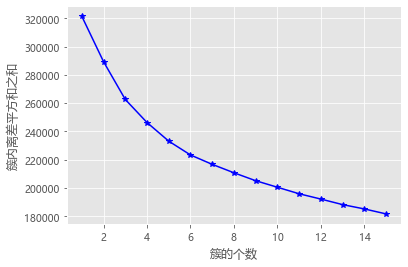

In [31]:
# 构造自定义函数，用于绘制不同k值和对应总的簇内离差平方和的折线图
def k_SSE(X, clusters):
    # 选择连续的K种不同的值
    K = range(1,clusters+1)
    # 构建空列表用于存储总的簇内离差平方和
    TSSE = []
    for k in tqdm(K):
        # 用于存储各个簇内离差平方和
        SSE = []
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        # 返回簇标签
        labels = kmeans.labels_
        # 返回簇中心
        centers = kmeans.cluster_centers_
        # 计算各簇样本的离差平方和，并保存到列表中
        for label in set(labels):
            SSE.append(np.sum((X.loc[labels == label,]-centers[label,:])**2))
        # 计算总的簇内离差平方和
        TSSE.append(np.sum(SSE))

    # 中文和负号的正常显示
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    # 设置绘图风格
    plt.style.use('ggplot')
    # 绘制K的个数与GSSE的关系
    plt.plot(K, TSSE, 'b*-')
    plt.xlabel('簇的个数')
    plt.ylabel('簇内离差平方和之和')
    # 显示图形
    plt.show()

# 自定义函数的调用
k_SSE(pd.DataFrame(train_vec), 15)


In [31]:
# 构造自定义函数，用于绘制不同k值和对应轮廓系数的折线图
def k_silhouette(X, clusters):
    K = range(2,clusters+1)
    # 构建空列表，用于存储个中簇数下的轮廓系数
    S = []
    for k in tqdm(K):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        labels = kmeans.labels_
        # 调用字模块metrics中的silhouette_score函数，计算轮廓系数
        score = sklearn.metrics.silhouette_score(X, labels, metric='euclidean')
        print(score)
        S.append(score)

    # 中文和负号的正常显示
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    # 设置绘图风格
    plt.style.use('ggplot')
    # 绘制K的个数与轮廓系数的关系
    plt.plot(K, S, 'b*-')
    plt.xlabel('簇的个数')
    plt.ylabel('轮廓系数')
    # 显示图形
    plt.show()

# 自定义函数的调用
k_silhouette(pd.DataFrame(train_vec), 100)



 55%|█████▍    | 54/99 [22:02<18:21, 24.49s/it]


0.24974919461612266
0.21990501157665618
0.2246336261023083
0.1941448042407507
0.200976523116704
0.2087050843591827
0.2187987265920855
0.22289769987076177
0.21701455579453868
0.22767340257876745
0.2326899031609354
0.24227055252270036
0.24421627830301543
0.24418963809232758
0.22976866691297224
0.2493443164183936
0.2261541025941682
0.25187193992611473
0.21923501984156687
0.22049553619041726
0.23556609727475183
0.22369277029748474
0.2247840810650942
0.23016797070238326
0.23366850906726438
0.22856820899344757
0.22054223443066073
0.2280226307598199
0.22882043329225518
0.22669722864169503
0.2308628703131148
0.22152771279165645
0.2192450068486761
0.21736268561710054
0.2067984710034606
0.2190992789163346
0.20304899845033322
0.21858320787726715
0.1996623790550193
0.21447910417960347
0.20535063352948818
0.20463261275424352
0.20048127557135917
0.1996090276381175
0.20667190152019924
0.20810530078006595
0.20613572657706522
0.20381155295975847
0.19816887943699757
0.2022063024141761
0.2055747467443205

KeyboardInterrupt: 